# Single point detection with mobilenetv2 backbone


In [1]:
import tensorflow as tf
import tensorflow_datasets as tfds
from tensorflow import keras
import numpy as np
import matplotlib.pyplot as plt
import matplotlib as mat
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score,confusion_matrix
import sklearn as skl
import pandas as pd
import seaborn as sns
import cv2
import keras_cv
import albumentations as A
import matplotlib.patches as patches




2024-11-17 15:27:58.761509: E external/local_xla/xla/stream_executor/plugin_registry.cc:91] Invalid plugin kind specified: FFT
2024-11-17 15:27:58.788004: I tensorflow/core/platform/cpu_feature_guard.cc:210] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: SSE3 SSE4.1 SSE4.2 AVX AVX2 AVX512F AVX512_VNNI AVX512_BF16 FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.
2024-11-17 15:27:59.183892: E external/local_xla/xla/stream_executor/plugin_registry.cc:91] Invalid plugin kind specified: DNN


In [2]:
print("TensorFlow version:", tf.__version__)
print("TensorFlow Datasets version:", tfds.__version__)
print("Keras version:", keras.__version__)
print("NumPy version:", np.__version__)
print("Matplotlib version:", mat.__version__)
print("Scikit-learn version:", skl.__version__)
print("Pandas version:", pd.__version__)
print("Seaborn version:", sns.__version__)
print("OpenCV version:", cv2.__version__)
print("keras_cv version:", keras_cv.__version__)
print("a version:", A.__version__)


TensorFlow version: 2.16.1
TensorFlow Datasets version: 4.9.3
Keras version: 3.5.0
NumPy version: 1.26.4
Matplotlib version: 3.7.5
Scikit-learn version: 1.5.2
Pandas version: 2.2.3
Seaborn version: 0.13.2
OpenCV version: 4.10.0
keras_cv version: 0.9.0
a version: 1.4.21


In [3]:
# constants for various parts of the model
IMAGE_CHANNELS = 3

# input image (ie image from esp 32 looks size)
IMAGE_HEIGHT = 240
IMAGE_WIDTH = 240
IMAGE_SHAPE = (IMAGE_HEIGHT, IMAGE_WIDTH, IMAGE_CHANNELS)

# pretrained MobileNetV2 model image size
BASE_MODEL_IMAGE_HEIGHT = 96
BASE_MODEL_IMAGE_WIDTH = 96
BASE_MODEL_IMAGE_SHAPE = (BASE_MODEL_IMAGE_HEIGHT, BASE_MODEL_IMAGE_WIDTH, IMAGE_CHANNELS)

# final model input shape (flat)
MODEL_INPUT_SHAPE = (IMAGE_CHANNELS * IMAGE_HEIGHT * IMAGE_WIDTH)

#BATCH_SIZE = 32

MODEL_SAVE_PATH = './model.keras'
LITE_MODEL_SAVE_PATH = './model.tflite'


## Preparing a Dataset

### Using an Existing Dataset

In [4]:
# Data set file location

# Load the dataset with the specified data directory ~25GB
ds_train, ds_validation = tfds.load('coco/2017', split=['train', 'validation'], data_dir='/root/tensorflow_datasets')

def augment_image(image, bounding_boxes, class_labels):
    translate_strength = 0.6 # 0 to 1
    rotate_strength = 10 # -360 to 360
    transform = A.Compose([
        A.HorizontalFlip(p=0.5),
        A.Affine(rotate=(-rotate_strength, rotate_strength), p=0.75, rotate_method='ellipse', mode=cv2.BORDER_REPLICATE),
        A.Affine(translate_percent={"x": (-translate_strength, translate_strength), "y": (-translate_strength, translate_strength)}, p=1, mode=cv2.BORDER_REPLICATE),
        # A.RandomBrightnessContrast(p=0.2),
        # A.RandomCrop(width=256, height=256, p=0.5),
        # Add more augmentations as needed
    ], bbox_params=A.BboxParams(format='albumentations', label_fields=['class_labels'], min_area=200))

    switched_bboxes = []
    for bbox in bounding_boxes:
        x_min, y_min, x_max, y_max = bbox
        epsilon = 1e-6
        # Albumentations expects min and maxes to not be equal
        y_min = np.clip(y_min - epsilon, 0, 1)
        x_min = np.clip(x_min - epsilon, 0, 1)
        y_max = np.clip(y_max + epsilon, 0, 1)
        x_max = np.clip(x_max + epsilon, 0, 1)
        switched_bboxes.append([y_min, x_min, y_max, x_max])
    bounding_boxes = switched_bboxes

    transformed = transform(image=image, bboxes=bounding_boxes, class_labels=class_labels)

    transformed_switched_bboxes = []
    for bbox in transformed['bboxes']:
        y_min, x_min, y_max, x_max = bbox
        transformed_switched_bboxes.append([x_min, y_min, x_max, y_max])
    return transformed['image'], transformed_switched_bboxes, transformed['class_labels']

def random_translate_image_and_label(image, bbox, labels):
    image_np = image
    bounding_boxes = bbox.tolist()
    class_labels = labels.tolist()

    augmented_image, augmented_bboxes, augmented_labels = augment_image(image_np, bounding_boxes, class_labels)

    return augmented_image, augmented_bboxes, augmented_labels

def tf_random_translate_image_and_label(example, apply_transform=True):
    image = example['image']
    bbox = example['objects']['bbox']
    labels = example['objects']['label']

    if apply_transform:
        augmented_image, augmented_bboxes, augmented_labels = tf.numpy_function(
            random_translate_image_and_label, [image, bbox, labels], [tf.uint8, tf.double, tf.double]
        )
        augmented_bboxes = tf.cast(augmented_bboxes, tf.float32)
        augmented_labels = tf.cast(augmented_labels, tf.int64)

        if tf.shape(augmented_bboxes)[0] == 0:
            augmented_bboxes = tf.zeros([0, 4], dtype=tf.float32)

        augmented_image.set_shape(image.shape)
        augmented_bboxes.set_shape([None, 4])

        example['image'] = augmented_image
        example['objects']['bbox'] = augmented_bboxes
        example['objects']['label'] = augmented_labels

    return example

# Apply random translation to the images and labels for training data only
ds_train = ds_train.map(lambda x: tf_random_translate_image_and_label(x, apply_transform=True))
ds_validation = ds_validation.map(lambda x: tf_random_translate_image_and_label(x, apply_transform=False))

2024-11-17 15:28:02.421404: I external/local_xla/xla/stream_executor/rocm/rocm_executor.cc:926] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2024-11-17 15:28:02.421468: I external/local_xla/xla/stream_executor/rocm/rocm_executor.cc:926] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2024-11-17 15:28:02.453247: I external/local_xla/xla/stream_executor/rocm/rocm_executor.cc:926] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2024-11-17 15:28:02.453301: I external/local_xla/xla/stream_executor/rocm/rocm_executor.cc:926] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2024-11-17 15:28:02.453337: I external/local_xla/xla/stream_executor/rocm/rocm_executor.

example


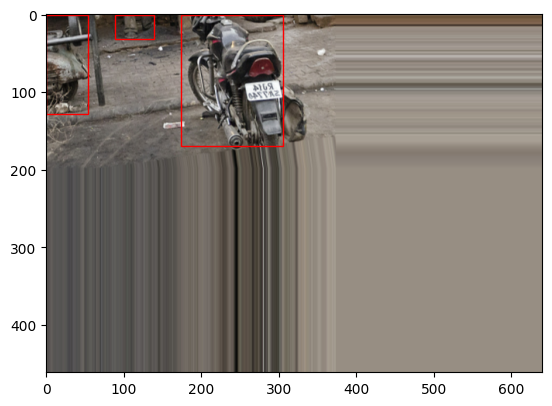

2024-11-17 15:28:03.088130: I tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence


In [5]:
# Function to display an image with bounding boxes
def display_image_with_bboxes(image, bboxes):
    fig, ax = plt.subplots(1)
    ax.imshow(image)

    # Add bounding boxes
    for bbox in bboxes:
        # Assuming bbox is in the format [y_min, x_min, y_max, x_max] and normalized
        y_min, x_min, y_max, x_max = bbox
        height, width, _ = image.shape
        x_min *= width
        x_max *= width
        y_min *= height
        y_max *= height
        rect = patches.Rectangle((x_min, y_min), x_max - x_min, y_max - y_min, linewidth=1, edgecolor='r', facecolor='none')
        ax.add_patch(rect)

    plt.show()
# Display 10 images from the dataset
for example in ds_train.take(1):
    print("example")

    image = example['image'].numpy()
    bboxes = example['objects']['bbox'].numpy()
    display_image_with_bboxes(image, bboxes)

In [6]:

# Define the label for 'person' in the dataset
# The original label is a list of objects classes with bounding boxes
# The label for 'person' in the COCO dataset is 0 there are 80 classes in the COCO dataset
# we will create a new label that is 1 if the object is a person and 0 otherwise
PREDICTION_GRID_SIZE = 24
COCO_PERSON_CLASS = 0 
def create_label(example):
    objects = example['objects']
    bbox = objects["bbox"]
    
    # Extract bounding box coordinates
    y_mins, x_mins, y_maxs, x_maxs = tf.unstack(bbox, axis=-1)
    
    # Calculate widths, heights, and centers
    widths = x_maxs - x_mins
    heights = y_maxs - y_mins
    x_centers = (x_mins + (widths / 2))
    y_centers = (y_mins + (heights / 2))
    areas = widths * heights
    object_centers = tf.stack([x_centers, y_centers], axis=-1)
    
    object_labels = objects['label']
    output = {'image': example['image']}
    
    # Filter for person class and not crowded
    # tf.print("object_labels",object_labels)
    # tf.print("eq",tf.equal(object_labels, COCO_PERSON_CLASS))

    person_centers_indices = tf.where(tf.equal(object_labels, COCO_PERSON_CLASS))
    # tf.print('pci',person_centers_indices)
    person_centers = tf.gather_nd(object_centers, person_centers_indices)
    person_count = tf.size(person_centers) // 2  # Each center has 2 coordinates (x, y)
    
    if tf.size(person_centers) == 0:
        output['label'] = {
            'person': tf.constant([[0]], dtype=tf.int32),
            'person_center': tf.random.uniform(shape=[2], minval=0, maxval=1, dtype=tf.float32),
            'person_count': tf.constant([[0]], dtype=tf.int32),
            'person_center_flat': tf.zeros([48 * 48], dtype=tf.float32)  # Flat 48x48 array with all zeros

        }
        return output
    
    # Find the largest person by area
    person_areas = tf.gather_nd(areas, person_centers_indices)
    largest_person_index = tf.argmax(person_areas)
    largest_person_center = tf.gather(person_centers, largest_person_index)
    # Create a 48x48 array and set the value at the person_center to 1
    person_center_array = tf.zeros([PREDICTION_GRID_SIZE, PREDICTION_GRID_SIZE], dtype=tf.float32)
    x_center = tf.cast(largest_person_center[0] * PREDICTION_GRID_SIZE, tf.int32)
    y_center = tf.cast(largest_person_center[1] * PREDICTION_GRID_SIZE, tf.int32)

    # Ensure the indices are within bounds
    x_center = tf.clip_by_value(x_center, 0, PREDICTION_GRID_SIZE-1)
    y_center = tf.clip_by_value(y_center, 0, PREDICTION_GRID_SIZE-1)

    # Set the value at the person_center to 1
    person_center_array = tf.tensor_scatter_nd_update(person_center_array, [[y_center, x_center]], [1.0])

    # Flatten the 48x48 array
    person_center_flat = tf.reshape(person_center_array, [PREDICTION_GRID_SIZE * PREDICTION_GRID_SIZE])
    output['label'] = {
        'person': tf.constant([[1]], dtype=tf.int32),
        'person_center': tf.reshape(largest_person_center, [2]),
        'person_center_flat': person_center_flat,
        'person_count': person_count
    }
    
    return output

def format_image(example):
    # Resize the image
    example["image"] = tf.image.resize(example["image"], [IMAGE_HEIGHT, IMAGE_WIDTH])
    # convert the pixel values to be between 0 and 1
    example["image"] = tf.cast(example["image"], tf.float32) / 255.0
    return example

# flatten image (flat image match the shape of images from the esp32 camera)
def flatten_image(example):
    example["image"] = tf.reshape(example["image"], (1,IMAGE_CHANNELS * IMAGE_HEIGHT * IMAGE_WIDTH,))
    return example
    
# tuple format (Training expects a tuple of (image, label))
def convert_to_tuple(example):
    # tf.print("label",example["label"])
    return (example["image"], example["label"])

def filter_single_person(example):
    return tf.equal(example['label']['person_count'], 1)

def remove_person_count(example):
    example['label'].pop('person_count')
    example['label'].pop('person_center')
    return example

# Apply the mapping functions to the dataset
ds_train = ds_train.map(create_label)
ds_validation = ds_validation.map(create_label)

# Filter the dataset to include only images with exactly one person
ds_train_one_person = ds_train.filter(filter_single_person)
ds_validation_one_person = ds_validation.filter(filter_single_person)

# Remove the 'person_count' field from the label
ds_train_one_person = ds_train_one_person.map(remove_person_count)
ds_validation_one_person = ds_validation_one_person.map(remove_person_count)
ds_train = ds_train.map(remove_person_count)
ds_validation = ds_validation.map(remove_person_count)
# Continue with the rest of the preprocessing steps
ds_train_one_person = ds_train_one_person.map(format_image)
ds_validation_one_person = ds_validation_one_person.map(format_image)
ds_train = ds_train.map(format_image)
ds_validation = ds_validation.map(format_image)

ds_train_one_person = ds_train_one_person.map(flatten_image)
ds_validation_one_person = ds_validation_one_person.map(flatten_image)
ds_train = ds_train.map(flatten_image)
ds_validation = ds_validation.map(flatten_image)

ds_train_one_person = ds_train_one_person.map(convert_to_tuple)
ds_validation_one_person = ds_validation_one_person.map(convert_to_tuple)
ds_train = ds_train.map(convert_to_tuple)
ds_validation = ds_validation.map(convert_to_tuple)

tf.Tensor(
[[3.8431373e-01 4.3921569e-01 4.8235294e-01 ... 4.0310062e-04
  3.6437955e-02 6.0621042e-02]], shape=(1, 172800), dtype=float32)
(1, 1)
(24, 24)
Person present: [[1]]
Center: [[0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.

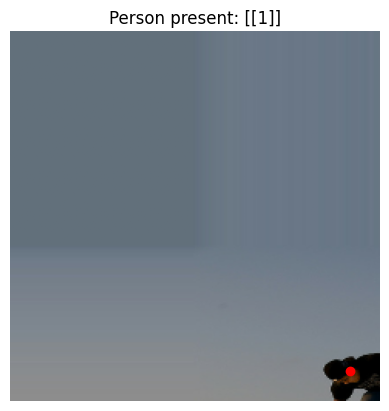

tf.Tensor([[0.61588097 0.6485185  0.38824347 ... 0.40784314 0.49019608 0.18431373]], shape=(1, 172800), dtype=float32)
(1, 1)
(24, 24)
Person present: [[1]]
Center: [[0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 1. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
 [0. 0. 0.

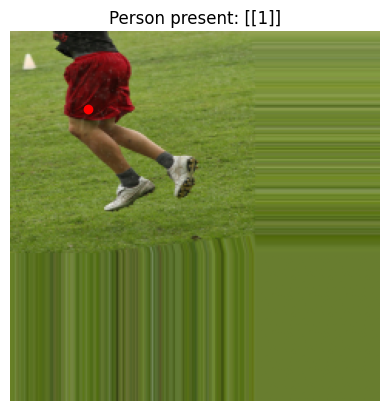

tf.Tensor([[0.17843138 0.13333334 0.11176471 ... 0.7176471  0.6862745  0.5032681 ]], shape=(1, 172800), dtype=float32)
(1, 1)
(24, 24)
Person present: [[1]]
Center: [[0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
 [0. 0. 0.

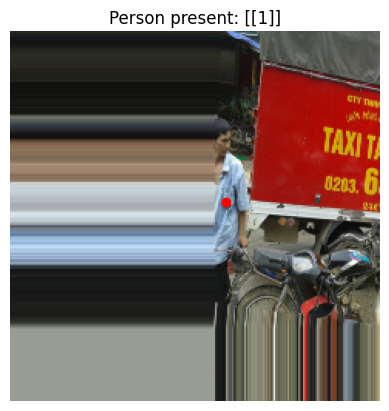

tf.Tensor([[0.07843138 0.08235294 0.05882353 ... 0.31261513 0.31991082 0.29507503]], shape=(1, 172800), dtype=float32)
(1, 1)
(24, 24)
Person present: [[1]]
Center: [[0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
 [0. 0. 0.

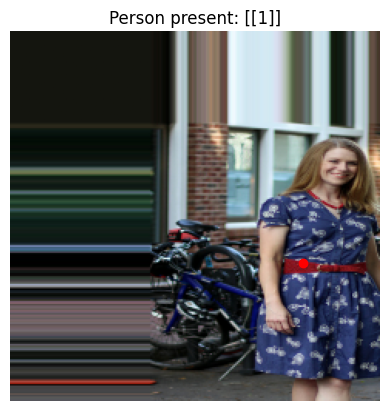

tf.Tensor([[0.7387402  0.737174   0.71933085 ... 0.18039216 0.09411765 0.10196079]], shape=(1, 172800), dtype=float32)
(1, 1)
(24, 24)
Person present: [[1]]
Center: [[0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
 [0. 0. 0.

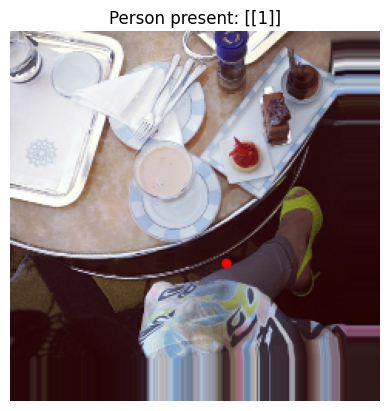

2024-11-17 15:28:05.160357: I tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence


In [7]:

# Iterate through the dataset and print an example
for example in ds_train_one_person.shuffle(100).take(5):
    image, label = example[0], example[1]
    person_present = label['person']
   # person_center = label['person_center']
    person_center_flat = label['person_center_flat']
    person_center_array = np.reshape(person_center_flat, (PREDICTION_GRID_SIZE, PREDICTION_GRID_SIZE))

  # Find the coordinates of the point with value 1
    y_center, x_center = np.unravel_index(np.argmax(person_center_array), person_center_array.shape)
    person_center = (x_center / PREDICTION_GRID_SIZE, y_center / PREDICTION_GRID_SIZE)
    print(image)
    print(person_present.shape)
    print(person_center_array.shape)
    print(f"Person present: {person_present.numpy()}")
    print(f"Center: {person_center_array}")

    
    # Display the image using Matplotlib
    plt.imshow(tf.reshape(image, (IMAGE_HEIGHT, IMAGE_WIDTH, IMAGE_CHANNELS)))
    plt.title(f"Person present: {person_present}")
    plt.plot(person_center[0] * IMAGE_WIDTH, person_center[1] * IMAGE_HEIGHT, 'ro')
    plt.axis('off')
    plt.show()



In [8]:
#TODO using a batched dataset breaks training?
# ds_train_batched = ds_train.shuffle(1024).batch(BATCH_SIZE).prefetch(tf.data.AUTOTUNE)
# for example in ds_train_batched.take(1):
#     print(example[0].shape)
#     print(example[1].shape)
# print(ds_train_batched)

## Create new layers to add to the the new model

In [9]:
# Creating layers for the new classifier
reshape_layer = tf.keras.layers.Reshape(IMAGE_SHAPE)

resize_layer = tf.keras.layers.Resizing(
    BASE_MODEL_IMAGE_HEIGHT,
    BASE_MODEL_IMAGE_WIDTH,
    interpolation='nearest',#"bilinear", "nearest" are compatible with tf micro
    crop_to_aspect_ratio=True
    )

In [10]:
flat_input = tf.keras.layers.Input(shape=(IMAGE_CHANNELS * IMAGE_HEIGHT * IMAGE_WIDTH,), name='image')
x = reshape_layer(flat_input)
x = resize_layer(x)
base_model =tf.keras.applications.MobileNetV2(
        input_shape=BASE_MODEL_IMAGE_SHAPE,
        alpha=0.35,
        include_top=False,# the top is the last layer of the model (the classifier)
        # we don't want to include it we will train our own final layer
        weights="imagenet",
        input_tensor=x,
        pooling=None,
        classes=1000,
        classifier_activation=None,
    )
# Freeze the base model because we only want to train the new classifier
# We don't want to train the base model because it has already learned many features
# training new features is more difficult than training the classifier and would require more data
base_model.trainable = False
#base_model.summary()

## Create the New Model
We will combine our layers with the base model to create a new model

In [ ]:



output_layers = [
    'block_1_expand_relu',   #Shape of base model output 99: (None, 48, 48, 48)
    'block_3_expand_relu',   #Shape of base model output 99: (None, 24, 24, 48)
    'block_6_expand_relu',   #Shape of base model output 99: (None, 12, 12, 96)
   # 'block_13_expand_relu',  #Shape of base model output 99: (None, 6, 6, 192)
    #'block_16_project',      #Shape of base model output 99: (None, 3, 3, 112)
]
#create the localiser branch needs multiple inputs
# for some reason getting these layers from the models 
# do not use the flat input
base_model_outputs = [base_model.get_layer(layer_name).output for layer_name in output_layers]

#track all added layers so we can stop training them

# Apply a 3x3 convolutional layer and then GlobalAveragePooling2D to each layer output
conv_and_pooled_outputs = []
for output in base_model_outputs:
    print(f"Shape of base model output : {output.shape}")
    print(f"Shape of base model output: {output.shape}")
    conv_output = tf.keras.layers.SeparableConv2D(filters=1024, kernel_size=(3, 3), padding='same', activation='relu')(output)
    #conv_output = tf.keras.layers.SeparableConv2D(filters=256, kernel_size=(5, 5), padding='same', activation='relu')(output)
    conv_output = tf.keras.layers.Dropout(0.1)(conv_output)
    pooled_output = tf.keras.layers.GlobalMaxPooling2D()(conv_output)
    print(f"Shape of pooled output: {pooled_output.shape}")
    conv_and_pooled_outputs.append(pooled_output)


# Example usage: concatenate the pooled outputs if needed
concatenated_outputs = tf.keras.layers.Concatenate()(conv_and_pooled_outputs)

locator_branch = tf.keras.layers.Dense(512, activation='relu', name='bb_1')(concatenated_outputs)
#locator_branch = tf.keras.layers.Dense(256, activation='relu', name='bb_2')(locator_branch)
#locator_branch = tf.keras.layers.Dense(128, activation='relu', name='bb_3')(locator_branch)
#locator_branch = tf.keras.layers.Dense(64, activation='relu', name='bb_4')(locator_branch)
locator_branch = tf.keras.layers.Dense(PREDICTION_GRID_SIZE*PREDICTION_GRID_SIZE, activation='sigmoid', name='person_center_flat')(locator_branch)


global_average_layer = tf.keras.layers.GlobalAveragePooling2D(name='person_global_average')
#feature_batch_average = global_average_layer(feature_batch)

# new binary classifier layer
prediction_layer = tf.keras.layers.Dense(1, activation='tanh', name='person')



x = global_average_layer(base_model.output)
x = tf.keras.layers.Dropout(0.2)(x)
outputs = [prediction_layer(x), locator_branch]
#outputs = prediction_layer(x)
model = tf.keras.Model(flat_input, outputs, name='person_detector')

# for layer in model.layers:
#     layer.trainable = False
#Make the layers untrainable while we first train on person center detection

model.get_layer('person_global_average').trainable = False
model.get_layer('person').trainable = False
model.summary()
input_shape = model.input_shape
print(f'Model input shape: {input_shape}')

Shape of base model output : (None, 48, 48, 48)
Shape of base model output: (None, 48, 48, 48)
Shape of pooled output: (None, 1024)
Shape of base model output : (None, 24, 24, 48)
Shape of base model output: (None, 24, 24, 48)
Shape of pooled output: (None, 1024)
Shape of base model output : (None, 12, 12, 96)
Shape of base model output: (None, 12, 12, 96)
Shape of pooled output: (None, 1024)
Model input shape: (None, 172800)


# Training the Model

In [ ]:
base_learning_rate = 0.0001

losses = {
    'person': tf.keras.losses.BinaryCrossentropy(),
    'person_center_flat': tf.keras.losses.CategoricalFocalCrossentropy(),
}
# Define the loss weights
loss_weights = {
    'person': 0.00,
    'person_center_flat': 1,  # Adjust this weight as needed
}
model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=base_learning_rate),
              loss= losses,
             loss_weights=loss_weights,
              metrics=['accuracy','MSE'])
#model.summary()

In [13]:

#model.evaluate(ba)
location_history = model.fit(ds_train_one_person,
                    epochs=20,
                    steps_per_epoch=5000,
                    batch_size=100,
                    validation_data=ds_validation_one_person
                    )
#model.evaluate(val_csv_dataset)
MODEL_PART_1_SAVE_PATH = './model_part1.keras'
model.save(MODEL_PART_1_SAVE_PATH)

Epoch 1/20


I0000 00:00:1731857288.442538    4442 service.cc:145] XLA service 0x76bb54004b30 initialized for platform ROCM (this does not guarantee that XLA will be used). Devices:
I0000 00:00:1731857288.442591    4442 service.cc:153]   StreamExecutor device (0): Radeon RX 7900 GRE, AMDGPU ISA version: gfx1100
2024-11-17 15:28:08.508738: I tensorflow/compiler/mlir/tensorflow/utils/dump_mlir_util.cc:268] disabling MLIR crash reproducer, set env var `MLIR_CRASH_REPRODUCER_DIRECTORY` to enable.
I0000 00:00:1731857290.194196    4442 device_compiler.h:188] Compiled cluster using XLA!  This line is logged at most once for the lifetime of the process.


5000/5000 ━━━━━━━━━━━━━━━━━━━━ 67s 13ms/step - loss: 1.5865 - person_accuracy: 0.3914 - person_center_flat_MSE: 0.1549 - person_center_flat_loss: 1.5865 - person_loss: 0.0000e+00 - val_loss: 1.5832 - val_person_accuracy: 0.4172 - val_person_center_flat_MSE: 0.1686 - val_person_center_flat_loss: 1.5832 - val_person_loss: 0.0000e+00
Epoch 2/20
  37/5000 ━━━━━━━━━━━━━━━━━━━━ 21s 4ms/step - loss: 1.5762 - person_accuracy: 0.2986 - person_center_flat_MSE: 0.1701 - person_center_flat_loss: 1.5762 - person_loss: 0.0000e+00

2024-11-17 15:29:13.124142: I tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
	 [[IteratorGetNext/_2]]
2024-11-17 15:29:13.124194: I tensorflow/core/framework/local_rendezvous.cc:423] Local rendezvous recv item cancelled. Key hash: 4470590573556760979
/usr/lib/python3.9/contextlib.py:137: UserWarning: Your input ran out of data; interrupting training. Make sure that your dataset or generator can generate at least `steps_per_epoch * epochs` batches. You may need to use the `.repeat()` function when building your dataset.
  self.gen.throw(typ, value, traceback)


5000/5000 ━━━━━━━━━━━━━━━━━━━━ 62s 12ms/step - loss: 1.5808 - person_accuracy: 0.4052 - person_center_flat_MSE: 0.1431 - person_center_flat_loss: 1.5808 - person_loss: 0.0000e+00 - val_loss: 1.5885 - val_person_accuracy: 0.4172 - val_person_center_flat_MSE: 0.0682 - val_person_center_flat_loss: 1.5885 - val_person_loss: 0.0000e+00
Epoch 3/20
  38/5000 ━━━━━━━━━━━━━━━━━━━━ 20s 4ms/step - loss: 1.5552 - person_accuracy: 0.4477 - person_center_flat_MSE: 0.0640 - person_center_flat_loss: 1.5552 - person_loss: 0.0000e+00

2024-11-17 15:30:15.607546: I tensorflow/core/framework/local_rendezvous.cc:423] Local rendezvous recv item cancelled. Key hash: 4470590573556760979
2024-11-17 15:30:15.607581: I tensorflow/core/framework/local_rendezvous.cc:423] Local rendezvous recv item cancelled. Key hash: 16902787424928037911
2024-11-17 15:30:15.607591: I tensorflow/core/framework/local_rendezvous.cc:423] Local rendezvous recv item cancelled. Key hash: 14794011747053172067


5000/5000 ━━━━━━━━━━━━━━━━━━━━ 62s 12ms/step - loss: 1.5779 - person_accuracy: 0.4121 - person_center_flat_MSE: 0.0805 - person_center_flat_loss: 1.5779 - person_loss: 0.0000e+00 - val_loss: 1.5912 - val_person_accuracy: 0.4172 - val_person_center_flat_MSE: 0.0478 - val_person_center_flat_loss: 1.5912 - val_person_loss: 0.0000e+00
Epoch 4/20
  39/5000 ━━━━━━━━━━━━━━━━━━━━ 20s 4ms/step - loss: 1.5882 - person_accuracy: 0.4561 - person_center_flat_MSE: 0.0623 - person_center_flat_loss: 1.5882 - person_loss: 0.0000e+00  

2024-11-17 15:31:17.519261: I tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
	 [[IteratorGetNext/_2]]
2024-11-17 15:31:17.519299: I tensorflow/core/framework/local_rendezvous.cc:423] Local rendezvous recv item cancelled. Key hash: 4470590573556760979
2024-11-17 15:31:17.519306: I tensorflow/core/framework/local_rendezvous.cc:423] Local rendezvous recv item cancelled. Key hash: 16902787424928037911
2024-11-17 15:31:17.519315: I tensorflow/core/framework/local_rendezvous.cc:423] Local rendezvous recv item cancelled. Key hash: 14794011747053172067


5000/5000 ━━━━━━━━━━━━━━━━━━━━ 62s 12ms/step - loss: 1.5727 - person_accuracy: 0.4079 - person_center_flat_MSE: 0.0667 - person_center_flat_loss: 1.5727 - person_loss: 0.0000e+00 - val_loss: 1.5837 - val_person_accuracy: 0.4172 - val_person_center_flat_MSE: 0.0571 - val_person_center_flat_loss: 1.5837 - val_person_loss: 0.0000e+00
Epoch 5/20
  26/5000 ━━━━━━━━━━━━━━━━━━━━ 20s 4ms/step - loss: 1.5712 - person_accuracy: 0.2664 - person_center_flat_MSE: 0.0597 - person_center_flat_loss: 1.5712 - person_loss: 0.0000e+00   

2024-11-17 15:32:19.677843: I tensorflow/core/framework/local_rendezvous.cc:423] Local rendezvous recv item cancelled. Key hash: 4470590573556760979
2024-11-17 15:32:19.677878: I tensorflow/core/framework/local_rendezvous.cc:423] Local rendezvous recv item cancelled. Key hash: 16902787424928037911
2024-11-17 15:32:19.677886: I tensorflow/core/framework/local_rendezvous.cc:423] Local rendezvous recv item cancelled. Key hash: 14794011747053172067


5000/5000 ━━━━━━━━━━━━━━━━━━━━ 62s 12ms/step - loss: 1.5564 - person_accuracy: 0.3841 - person_center_flat_MSE: 0.0509 - person_center_flat_loss: 1.5564 - person_loss: 0.0000e+00 - val_loss: 1.5656 - val_person_accuracy: 0.4172 - val_person_center_flat_MSE: 0.0129 - val_person_center_flat_loss: 1.5656 - val_person_loss: 0.0000e+00
Epoch 6/20
  35/5000 ━━━━━━━━━━━━━━━━━━━━ 22s 5ms/step - loss: 1.4888 - person_accuracy: 0.4496 - person_center_flat_MSE: 0.0106 - person_center_flat_loss: 1.4888 - person_loss: 0.0000e+00  

2024-11-17 15:33:21.623958: I tensorflow/core/framework/local_rendezvous.cc:423] Local rendezvous recv item cancelled. Key hash: 4470590573556760979
2024-11-17 15:33:21.623993: I tensorflow/core/framework/local_rendezvous.cc:423] Local rendezvous recv item cancelled. Key hash: 16902787424928037911
2024-11-17 15:33:21.624002: I tensorflow/core/framework/local_rendezvous.cc:423] Local rendezvous recv item cancelled. Key hash: 14794011747053172067


2272/5000 ━━━━━━━━━━━━━━━━━━━━ 32s 12ms/step - loss: 1.4865 - person_accuracy: 0.4182 - person_center_flat_MSE: 0.0079 - person_center_flat_loss: 1.4865 - person_loss: 0.0000e+00

2024-11-17 15:33:48.470927: I tensorflow/core/framework/local_rendezvous.cc:423] Local rendezvous recv item cancelled. Key hash: 4470590573556760979
2024-11-17 15:33:48.470970: I tensorflow/core/framework/local_rendezvous.cc:423] Local rendezvous recv item cancelled. Key hash: 16902787424928037911
2024-11-17 15:33:48.470981: I tensorflow/core/framework/local_rendezvous.cc:423] Local rendezvous recv item cancelled. Key hash: 14794011747053172067


5000/5000 ━━━━━━━━━━━━━━━━━━━━ 30s 6ms/step - loss: 1.4821 - person_accuracy: 0.4132 - person_center_flat_MSE: 0.0074 - person_center_flat_loss: 1.4821 - person_loss: 0.0000e+00 - val_loss: 1.5663 - val_person_accuracy: 0.4172 - val_person_center_flat_MSE: 0.0055 - val_person_center_flat_loss: 1.5663 - val_person_loss: 0.0000e+00
Epoch 7/20
   8/5000 ━━━━━━━━━━━━━━━━━━━━ 38s 8ms/step - loss: 1.4838 - person_accuracy: 0.6025 - person_center_flat_MSE: 0.0086 - person_center_flat_loss: 1.4838 - person_loss: 0.0000e+00  

2024-11-17 15:33:51.420009: I tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
	 [[IteratorGetNext/_2]]


5000/5000 ━━━━━━━━━━━━━━━━━━━━ 61s 12ms/step - loss: 1.4431 - person_accuracy: 0.3894 - person_center_flat_MSE: 0.0038 - person_center_flat_loss: 1.4431 - person_loss: 0.0000e+00 - val_loss: 1.5579 - val_person_accuracy: 0.4172 - val_person_center_flat_MSE: 0.0022 - val_person_center_flat_loss: 1.5579 - val_person_loss: 0.0000e+00
Epoch 8/20
  40/5000 ━━━━━━━━━━━━━━━━━━━━ 20s 4ms/step - loss: 1.3171 - person_accuracy: 0.3466 - person_center_flat_MSE: 0.0020 - person_center_flat_loss: 1.3171 - person_loss: 0.0000e+00  

2024-11-17 15:34:52.236028: I tensorflow/core/framework/local_rendezvous.cc:423] Local rendezvous recv item cancelled. Key hash: 4470590573556760979
2024-11-17 15:34:52.236062: I tensorflow/core/framework/local_rendezvous.cc:423] Local rendezvous recv item cancelled. Key hash: 16902787424928037911
2024-11-17 15:34:52.236074: I tensorflow/core/framework/local_rendezvous.cc:423] Local rendezvous recv item cancelled. Key hash: 14794011747053172067


5000/5000 ━━━━━━━━━━━━━━━━━━━━ 62s 12ms/step - loss: 1.3532 - person_accuracy: 0.3936 - person_center_flat_MSE: 0.0019 - person_center_flat_loss: 1.3532 - person_loss: 0.0000e+00 - val_loss: 1.5231 - val_person_accuracy: 0.4172 - val_person_center_flat_MSE: 0.0018 - val_person_center_flat_loss: 1.5231 - val_person_loss: 0.0000e+00
Epoch 9/20
  40/5000 ━━━━━━━━━━━━━━━━━━━━ 19s 4ms/step - loss: 1.3204 - person_accuracy: 0.5773 - person_center_flat_MSE: 0.0018 - person_center_flat_loss: 1.3204 - person_loss: 0.0000e+00

2024-11-17 15:35:54.563025: I tensorflow/core/framework/local_rendezvous.cc:423] Local rendezvous recv item cancelled. Key hash: 4470590573556760979
2024-11-17 15:35:54.563061: I tensorflow/core/framework/local_rendezvous.cc:423] Local rendezvous recv item cancelled. Key hash: 16902787424928037911
2024-11-17 15:35:54.563071: I tensorflow/core/framework/local_rendezvous.cc:423] Local rendezvous recv item cancelled. Key hash: 14794011747053172067


5000/5000 ━━━━━━━━━━━━━━━━━━━━ 61s 12ms/step - loss: 1.3197 - person_accuracy: 0.4050 - person_center_flat_MSE: 0.0018 - person_center_flat_loss: 1.3197 - person_loss: 0.0000e+00 - val_loss: 1.5133 - val_person_accuracy: 0.4172 - val_person_center_flat_MSE: 0.0018 - val_person_center_flat_loss: 1.5133 - val_person_loss: 0.0000e+00
Epoch 10/20
  41/5000 ━━━━━━━━━━━━━━━━━━━━ 19s 4ms/step - loss: 1.2841 - person_accuracy: 0.2597 - person_center_flat_MSE: 0.0017 - person_center_flat_loss: 1.2841 - person_loss: 0.0000e+00  

2024-11-17 15:36:55.813163: I tensorflow/core/framework/local_rendezvous.cc:423] Local rendezvous recv item cancelled. Key hash: 4470590573556760979
2024-11-17 15:36:55.813199: I tensorflow/core/framework/local_rendezvous.cc:423] Local rendezvous recv item cancelled. Key hash: 16902787424928037911
2024-11-17 15:36:55.813209: I tensorflow/core/framework/local_rendezvous.cc:423] Local rendezvous recv item cancelled. Key hash: 14794011747053172067


5000/5000 ━━━━━━━━━━━━━━━━━━━━ 62s 12ms/step - loss: 1.2905 - person_accuracy: 0.4000 - person_center_flat_MSE: 0.0017 - person_center_flat_loss: 1.2905 - person_loss: 0.0000e+00 - val_loss: 1.4494 - val_person_accuracy: 0.4172 - val_person_center_flat_MSE: 0.0017 - val_person_center_flat_loss: 1.4494 - val_person_loss: 0.0000e+00
Epoch 11/20
  43/5000 ━━━━━━━━━━━━━━━━━━━━ 18s 4ms/step - loss: 1.2202 - person_accuracy: 0.3176 - person_center_flat_MSE: 0.0017 - person_center_flat_loss: 1.2202 - person_loss: 0.0000e+00  

2024-11-17 15:37:57.404751: I tensorflow/core/framework/local_rendezvous.cc:423] Local rendezvous recv item cancelled. Key hash: 4470590573556760979
2024-11-17 15:37:57.404785: I tensorflow/core/framework/local_rendezvous.cc:423] Local rendezvous recv item cancelled. Key hash: 16902787424928037911
2024-11-17 15:37:57.404795: I tensorflow/core/framework/local_rendezvous.cc:423] Local rendezvous recv item cancelled. Key hash: 14794011747053172067


5000/5000 ━━━━━━━━━━━━━━━━━━━━ 61s 12ms/step - loss: 1.2618 - person_accuracy: 0.3875 - person_center_flat_MSE: 0.0017 - person_center_flat_loss: 1.2618 - person_loss: 0.0000e+00 - val_loss: 1.4271 - val_person_accuracy: 0.4172 - val_person_center_flat_MSE: 0.0017 - val_person_center_flat_loss: 1.4271 - val_person_loss: 0.0000e+00
Epoch 12/20
  39/5000 ━━━━━━━━━━━━━━━━━━━━ 20s 4ms/step - loss: 1.2131 - person_accuracy: 0.2945 - person_center_flat_MSE: 0.0017 - person_center_flat_loss: 1.2131 - person_loss: 0.0000e+00  

2024-11-17 15:38:58.158308: I tensorflow/core/framework/local_rendezvous.cc:423] Local rendezvous recv item cancelled. Key hash: 4470590573556760979
2024-11-17 15:38:58.158342: I tensorflow/core/framework/local_rendezvous.cc:423] Local rendezvous recv item cancelled. Key hash: 16902787424928037911
2024-11-17 15:38:58.158351: I tensorflow/core/framework/local_rendezvous.cc:423] Local rendezvous recv item cancelled. Key hash: 14794011747053172067


5000/5000 ━━━━━━━━━━━━━━━━━━━━ 31s 6ms/step - loss: 1.2555 - person_accuracy: 0.3940 - person_center_flat_MSE: 0.0017 - person_center_flat_loss: 1.2555 - person_loss: 0.0000e+00 - val_loss: 1.4287 - val_person_accuracy: 0.4172 - val_person_center_flat_MSE: 0.0017 - val_person_center_flat_loss: 1.4287 - val_person_loss: 0.0000e+00
Epoch 13/20
   6/5000 ━━━━━━━━━━━━━━━━━━━━ 54s 11ms/step - loss: 1.2736 - person_accuracy: 1.0000 - person_center_flat_MSE: 0.0017 - person_center_flat_loss: 1.2736 - person_loss: 0.0000e+00  

2024-11-17 15:39:29.260027: I tensorflow/core/framework/local_rendezvous.cc:423] Local rendezvous recv item cancelled. Key hash: 4470590573556760979
2024-11-17 15:39:29.260060: I tensorflow/core/framework/local_rendezvous.cc:423] Local rendezvous recv item cancelled. Key hash: 16902787424928037911
2024-11-17 15:39:29.260067: I tensorflow/core/framework/local_rendezvous.cc:423] Local rendezvous recv item cancelled. Key hash: 14794011747053172067


5000/5000 ━━━━━━━━━━━━━━━━━━━━ 61s 12ms/step - loss: 1.2332 - person_accuracy: 0.4096 - person_center_flat_MSE: 0.0017 - person_center_flat_loss: 1.2332 - person_loss: 0.0000e+00 - val_loss: 1.4127 - val_person_accuracy: 0.4172 - val_person_center_flat_MSE: 0.0017 - val_person_center_flat_loss: 1.4127 - val_person_loss: 0.0000e+00
Epoch 14/20
  41/5000 ━━━━━━━━━━━━━━━━━━━━ 19s 4ms/step - loss: 1.1952 - person_accuracy: 0.5280 - person_center_flat_MSE: 0.0017 - person_center_flat_loss: 1.1952 - person_loss: 0.0000e+00

2024-11-17 15:40:30.686326: I tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
	 [[IteratorGetNext/_2]]


5000/5000 ━━━━━━━━━━━━━━━━━━━━ 62s 12ms/step - loss: 1.2098 - person_accuracy: 0.4197 - person_center_flat_MSE: 0.0017 - person_center_flat_loss: 1.2098 - person_loss: 0.0000e+00 - val_loss: 1.4088 - val_person_accuracy: 0.4172 - val_person_center_flat_MSE: 0.0017 - val_person_center_flat_loss: 1.4088 - val_person_loss: 0.0000e+00
Epoch 15/20
  41/5000 ━━━━━━━━━━━━━━━━━━━━ 19s 4ms/step - loss: 1.2803 - person_accuracy: 0.3743 - person_center_flat_MSE: 0.0017 - person_center_flat_loss: 1.2803 - person_loss: 0.0000e+00  

2024-11-17 15:41:33.081050: I tensorflow/core/framework/local_rendezvous.cc:423] Local rendezvous recv item cancelled. Key hash: 4470590573556760979
2024-11-17 15:41:33.081084: I tensorflow/core/framework/local_rendezvous.cc:423] Local rendezvous recv item cancelled. Key hash: 16902787424928037911
2024-11-17 15:41:33.081094: I tensorflow/core/framework/local_rendezvous.cc:423] Local rendezvous recv item cancelled. Key hash: 14794011747053172067


5000/5000 ━━━━━━━━━━━━━━━━━━━━ 62s 12ms/step - loss: 1.2121 - person_accuracy: 0.4018 - person_center_flat_MSE: 0.0017 - person_center_flat_loss: 1.2121 - person_loss: 0.0000e+00 - val_loss: 1.4055 - val_person_accuracy: 0.4172 - val_person_center_flat_MSE: 0.0017 - val_person_center_flat_loss: 1.4055 - val_person_loss: 0.0000e+00
Epoch 16/20
  40/5000 ━━━━━━━━━━━━━━━━━━━━ 19s 4ms/step - loss: 1.3096 - person_accuracy: 0.5220 - person_center_flat_MSE: 0.0017 - person_center_flat_loss: 1.3096 - person_loss: 0.0000e+00

2024-11-17 15:42:34.857834: I tensorflow/core/framework/local_rendezvous.cc:423] Local rendezvous recv item cancelled. Key hash: 4470590573556760979
2024-11-17 15:42:34.857872: I tensorflow/core/framework/local_rendezvous.cc:423] Local rendezvous recv item cancelled. Key hash: 16902787424928037911
2024-11-17 15:42:34.857880: I tensorflow/core/framework/local_rendezvous.cc:423] Local rendezvous recv item cancelled. Key hash: 14794011747053172067


5000/5000 ━━━━━━━━━━━━━━━━━━━━ 62s 12ms/step - loss: 1.2060 - person_accuracy: 0.4169 - person_center_flat_MSE: 0.0017 - person_center_flat_loss: 1.2060 - person_loss: 0.0000e+00 - val_loss: 1.3763 - val_person_accuracy: 0.4172 - val_person_center_flat_MSE: 0.0017 - val_person_center_flat_loss: 1.3763 - val_person_loss: 0.0000e+00
Epoch 17/20
5000/5000 ━━━━━━━━━━━━━━━━━━━━ 61s 12ms/step - loss: 1.2027 - person_accuracy: 0.4125 - person_center_flat_MSE: 0.0017 - person_center_flat_loss: 1.2027 - person_loss: 0.0000e+00 - val_loss: 1.4046 - val_person_accuracy: 0.4172 - val_person_center_flat_MSE: 0.0017 - val_person_center_flat_loss: 1.4046 - val_person_loss: 0.0000e+00
Epoch 18/20
  39/5000 ━━━━━━━━━━━━━━━━━━━━ 20s 4ms/step - loss: 1.2220 - person_accuracy: 0.3632 - person_center_flat_MSE: 0.0017 - person_center_flat_loss: 1.2220 - person_loss: 0.0000e+00

2024-11-17 15:44:37.840115: I tensorflow/core/framework/local_rendezvous.cc:423] Local rendezvous recv item cancelled. Key hash: 4470590573556760979
2024-11-17 15:44:37.840150: I tensorflow/core/framework/local_rendezvous.cc:423] Local rendezvous recv item cancelled. Key hash: 16902787424928037911
2024-11-17 15:44:37.840161: I tensorflow/core/framework/local_rendezvous.cc:423] Local rendezvous recv item cancelled. Key hash: 14794011747053172067


2426/5000 ━━━━━━━━━━━━━━━━━━━━ 29s 12ms/step - loss: 1.1968 - person_accuracy: 0.3960 - person_center_flat_MSE: 0.0017 - person_center_flat_loss: 1.1968 - person_loss: 0.0000e+00

2024-11-17 15:45:05.815505: I tensorflow/core/framework/local_rendezvous.cc:423] Local rendezvous recv item cancelled. Key hash: 4470590573556760979
2024-11-17 15:45:05.815537: I tensorflow/core/framework/local_rendezvous.cc:423] Local rendezvous recv item cancelled. Key hash: 16902787424928037911
2024-11-17 15:45:05.815546: I tensorflow/core/framework/local_rendezvous.cc:423] Local rendezvous recv item cancelled. Key hash: 14794011747053172067


5000/5000 ━━━━━━━━━━━━━━━━━━━━ 31s 6ms/step - loss: 1.1966 - person_accuracy: 0.3949 - person_center_flat_MSE: 0.0017 - person_center_flat_loss: 1.1966 - person_loss: 0.0000e+00 - val_loss: 1.3859 - val_person_accuracy: 0.4172 - val_person_center_flat_MSE: 0.0017 - val_person_center_flat_loss: 1.3859 - val_person_loss: 0.0000e+00
Epoch 19/20
   7/5000 ━━━━━━━━━━━━━━━━━━━━ 47s 10ms/step - loss: 1.2498 - person_accuracy: 0.6554 - person_center_flat_MSE: 0.0017 - person_center_flat_loss: 1.2498 - person_loss: 0.0000e+00 

2024-11-17 15:45:08.591161: I tensorflow/core/framework/local_rendezvous.cc:423] Local rendezvous recv item cancelled. Key hash: 4470590573556760979
2024-11-17 15:45:08.591197: I tensorflow/core/framework/local_rendezvous.cc:423] Local rendezvous recv item cancelled. Key hash: 16902787424928037911
2024-11-17 15:45:08.591206: I tensorflow/core/framework/local_rendezvous.cc:423] Local rendezvous recv item cancelled. Key hash: 14794011747053172067


5000/5000 ━━━━━━━━━━━━━━━━━━━━ 62s 12ms/step - loss: 1.1772 - person_accuracy: 0.3825 - person_center_flat_MSE: 0.0017 - person_center_flat_loss: 1.1772 - person_loss: 0.0000e+00 - val_loss: 1.3615 - val_person_accuracy: 0.4172 - val_person_center_flat_MSE: 0.0017 - val_person_center_flat_loss: 1.3615 - val_person_loss: 0.0000e+00
Epoch 20/20
  40/5000 ━━━━━━━━━━━━━━━━━━━━ 19s 4ms/step - loss: 1.1214 - person_accuracy: 0.1899 - person_center_flat_MSE: 0.0017 - person_center_flat_loss: 1.1214 - person_loss: 0.0000e+00  

2024-11-17 15:46:10.420486: I tensorflow/core/framework/local_rendezvous.cc:423] Local rendezvous recv item cancelled. Key hash: 4470590573556760979
2024-11-17 15:46:10.420520: I tensorflow/core/framework/local_rendezvous.cc:423] Local rendezvous recv item cancelled. Key hash: 16902787424928037911
2024-11-17 15:46:10.420530: I tensorflow/core/framework/local_rendezvous.cc:423] Local rendezvous recv item cancelled. Key hash: 14794011747053172067


5000/5000 ━━━━━━━━━━━━━━━━━━━━ 63s 13ms/step - loss: 1.1736 - person_accuracy: 0.3904 - person_center_flat_MSE: 0.0017 - person_center_flat_loss: 1.1736 - person_loss: 0.0000e+00 - val_loss: 1.3738 - val_person_accuracy: 0.4172 - val_person_center_flat_MSE: 0.0017 - val_person_center_flat_loss: 1.3738 - val_person_loss: 0.0000e+00


2024-11-17 15:47:13.241903: I tensorflow/core/framework/local_rendezvous.cc:423] Local rendezvous recv item cancelled. Key hash: 4470590573556760979
2024-11-17 15:47:13.241940: I tensorflow/core/framework/local_rendezvous.cc:423] Local rendezvous recv item cancelled. Key hash: 16902787424928037911
2024-11-17 15:47:13.241951: I tensorflow/core/framework/local_rendezvous.cc:423] Local rendezvous recv item cancelled. Key hash: 14794011747053172067


In [14]:
# for layer in model.layers:
#     layer.trainable = False
# #Make the layers untrainable while we first train on person center detection
# model.get_layer(name='person_global_average').trainable = True
# model.get_layer(name='person').trainable = True
# base_learning_rate = 0.001

# losses = {
#     'person': tf.keras.losses.BinaryCrossentropy(),
#     'person_center': tf.keras.losses.Huber(),
# }
# # Define the loss weights
# loss_weights = {
#     'person': 1,
#     'person_center': 0,  # Adjust this weight as needed
# }
# model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=base_learning_rate),
#               loss= losses,
#              loss_weights=loss_weights,
#               metrics=['accuracy','MSE'])
# #model.summary()
# class_history = model.fit(ds_train,
#                     epochs=3,
#                     steps_per_epoch=5000,
#                     batch_size=10,
#                     validation_data=ds_validation
#                     )
# #model.evaluate(val_csv_dataset)
# MODEL_PART_2_SAVE_PATH = './model_part2.keras'
# model.save(MODEL_PART_2_SAVE_PATH)

In [15]:
# import matplotlib.pyplot as plt

# # Extract metrics from the history object
# person_center_mse = location_history.history['person_center_MSE']
# val_person_center_mse = location_history.history['val_person_center_MSE']
# person_acc = class_history.history['person_accuracy']
# val_person_acc = class_history.history['val_person_accuracy']
# epochs = range(1, max(len(person_center_mse),len(person_acc)) + 1)

# # Plot accuracy
# plt.figure(figsize=(12, 4))

# # Plot person center MSE
# plt.subplot(1, 2, 1)
# plt.plot(epochs, person_center_mse, 'bo-', label='Training person center MSE')
# plt.plot(epochs, val_person_center_mse, 'ro-', label='Validation person center MSE')
# plt.title('Training and validation person center MSE')
# plt.xlabel('Epochs')
# plt.ylabel('Person Center MSE')
# plt.legend()

# # Plot person accuracy
# plt.subplot(1, 2, 2)
# plt.plot(epochs, person_acc, 'bo-', label='Training person accuracy')
# plt.plot(epochs, val_person_acc, 'ro-', label='Validation person accuracy')
# plt.title('Training and validation person accuracy')
# plt.xlabel('Epochs')
# plt.ylabel('Person Accuracy')
# plt.legend()

# plt.show()

In [16]:
model = tf.keras.models.load_model('./model_part1.keras')


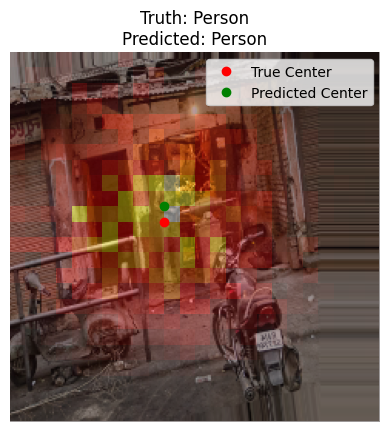

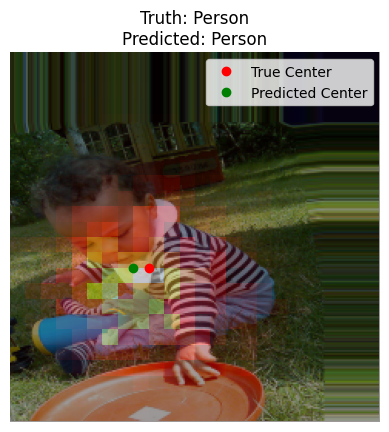

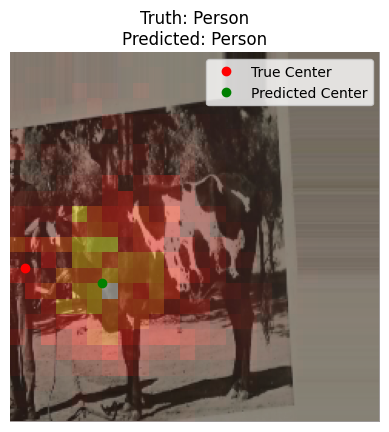

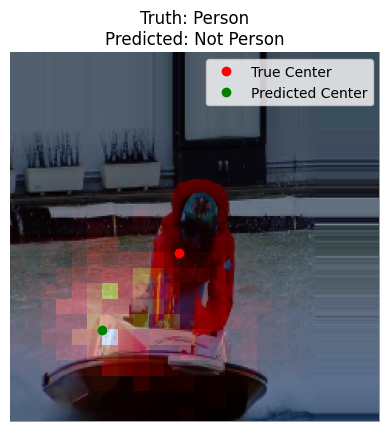

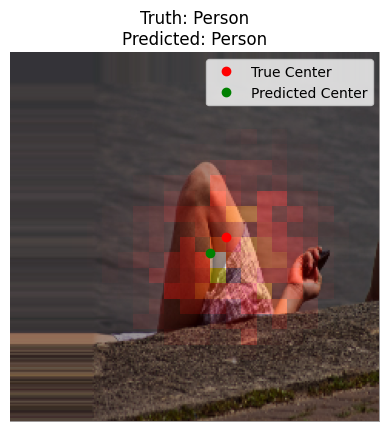

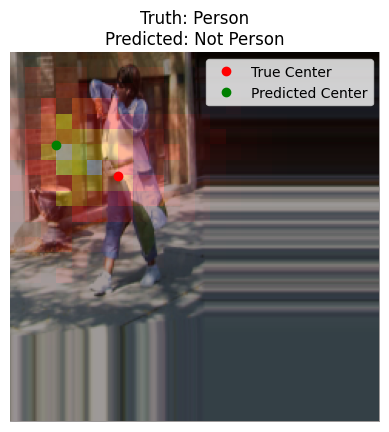

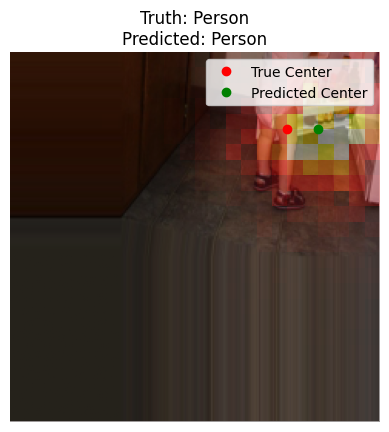

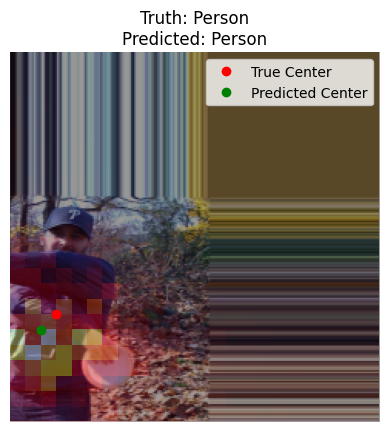

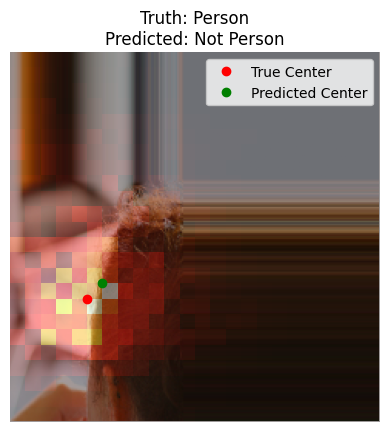

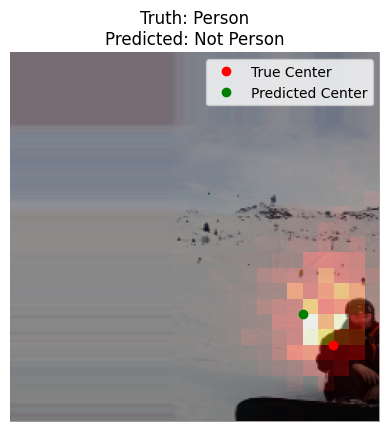

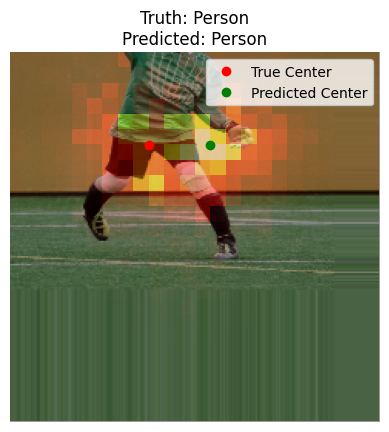

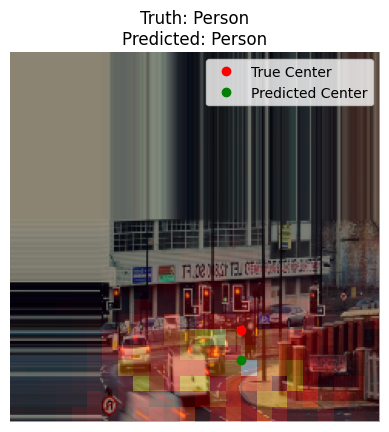

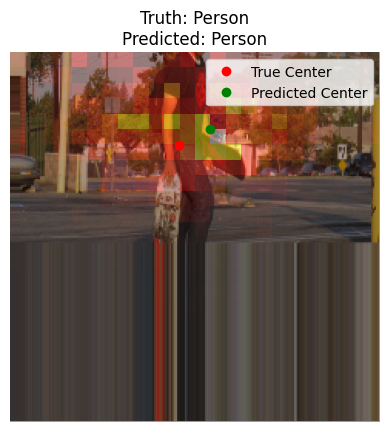

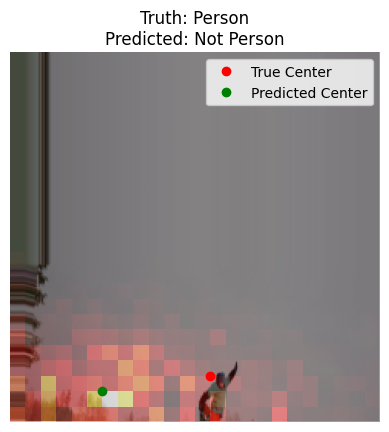

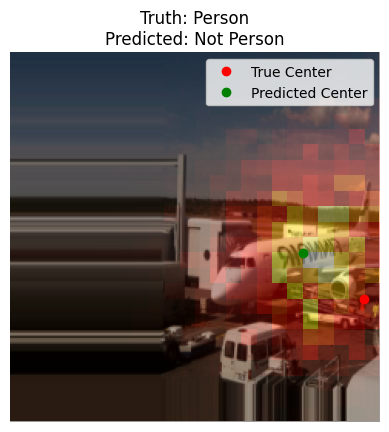

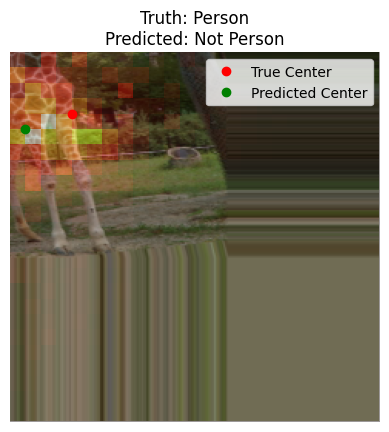

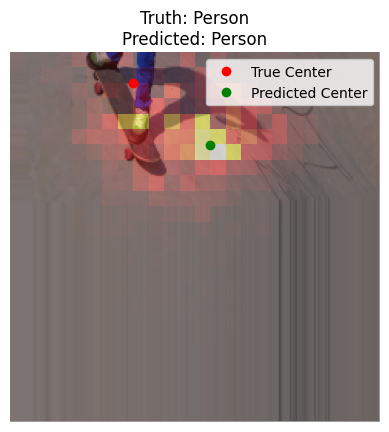

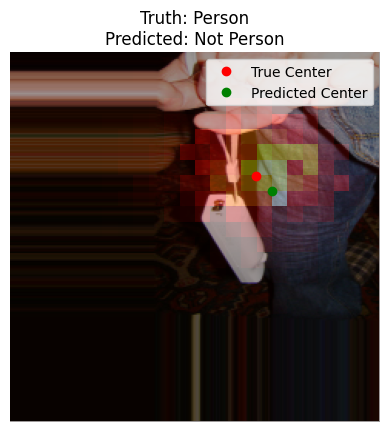

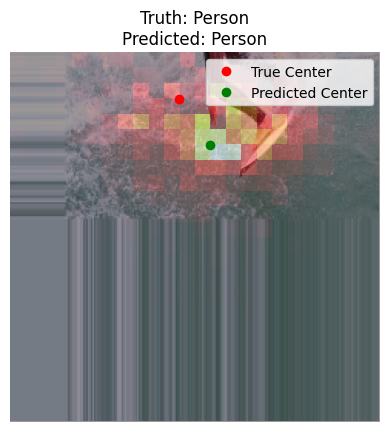

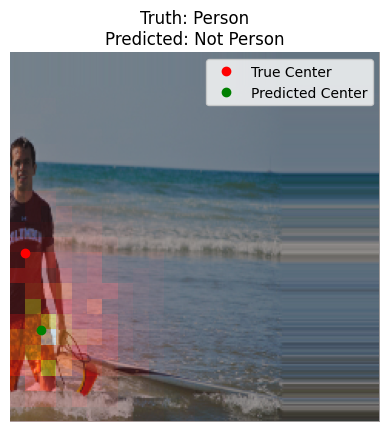

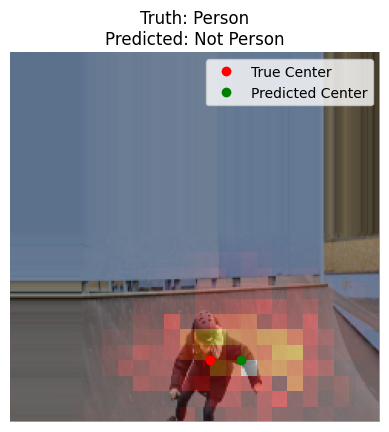

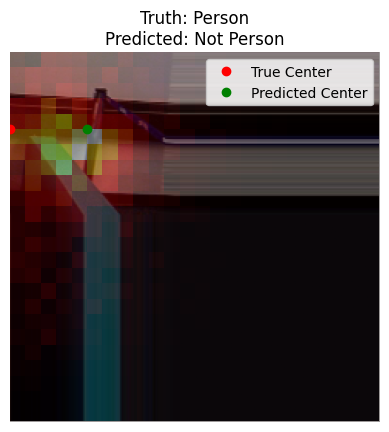

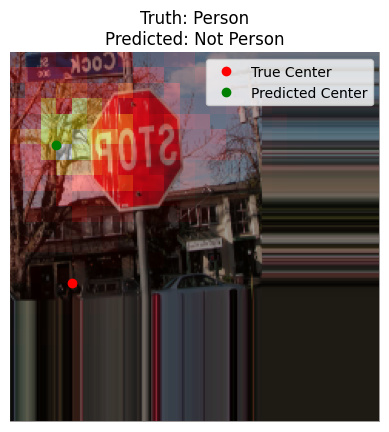

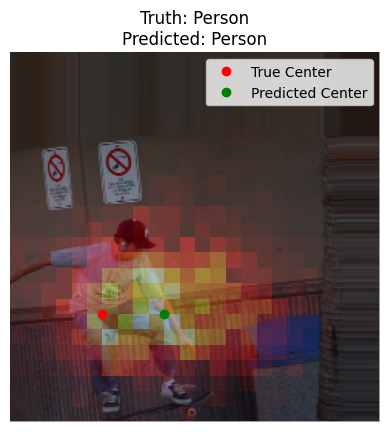

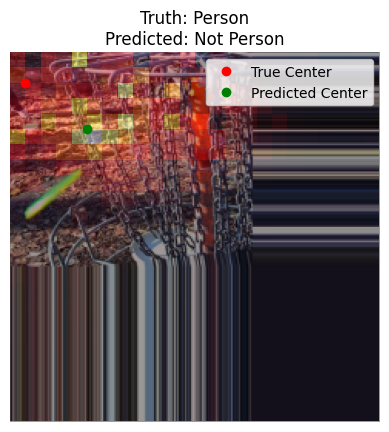

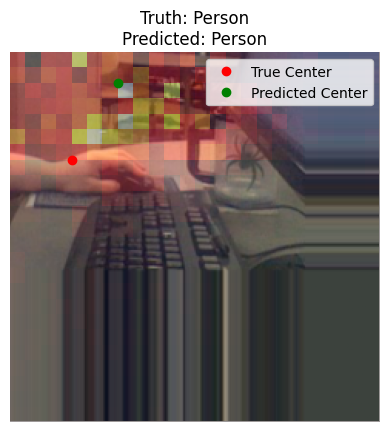

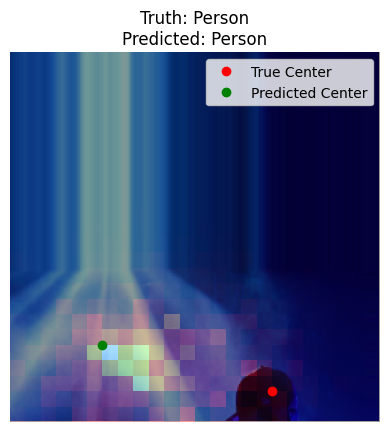

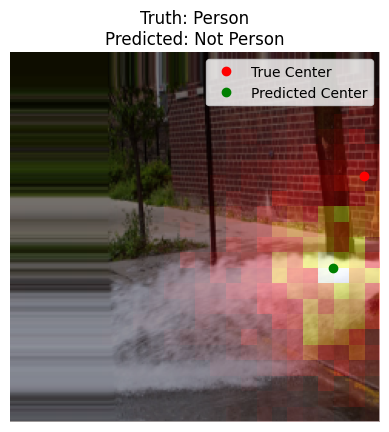

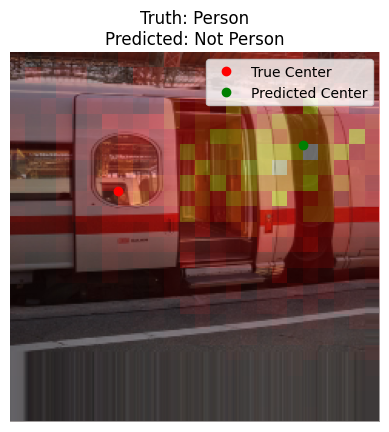

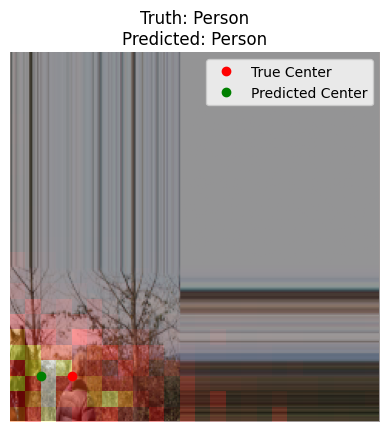

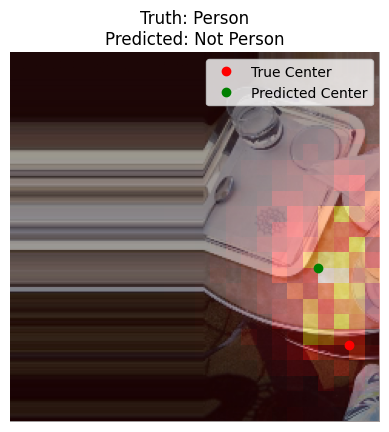

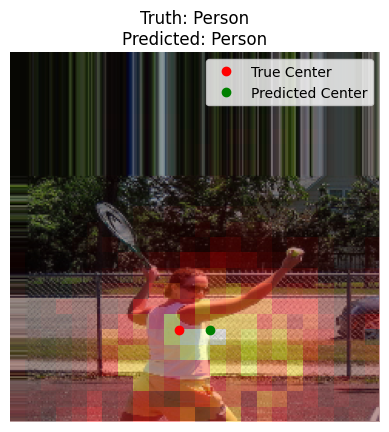

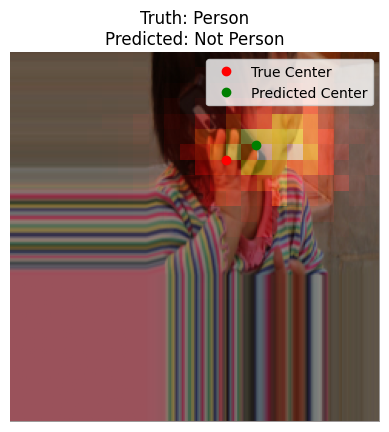

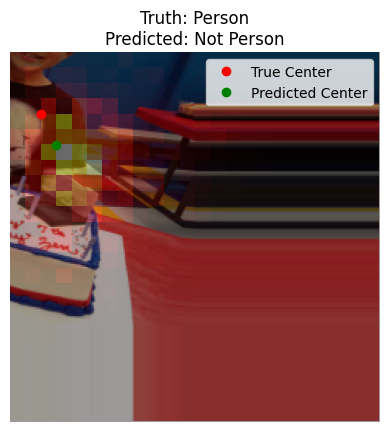

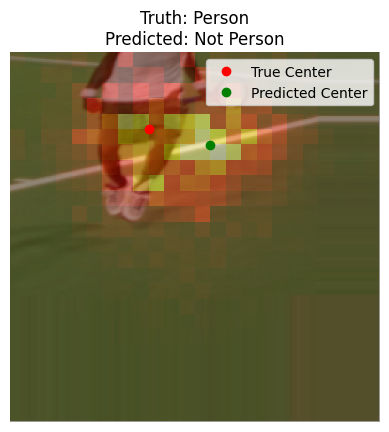

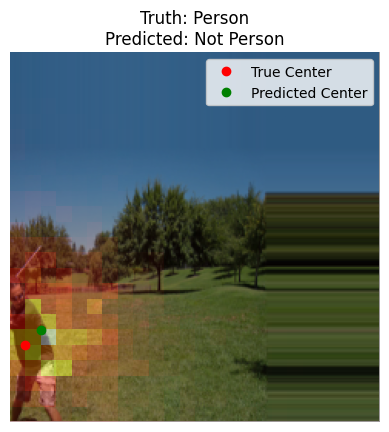

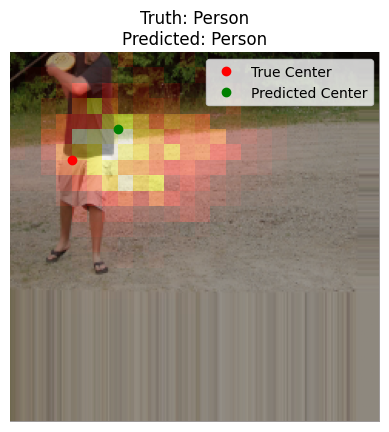

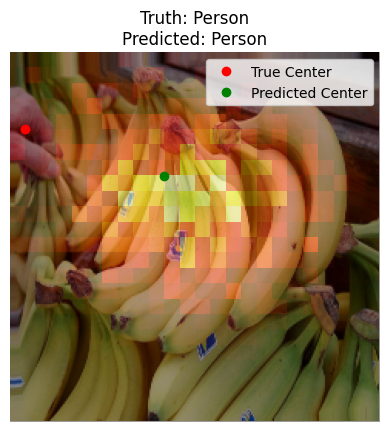

In [ ]:
import matplotlib.pyplot as plt
import numpy as np
import tensorflow as tf

# Assuming IMAGE_HEIGHT, IMAGE_WIDTH, and IMAGE_CHANNELS are defined
# IMAGE_HEIGHT = 256
# IMAGE_WIDTH = 256
# IMAGE_CHANNELS = 3
# PREDICTION_GRID_SIZE = 48

true_x = []
true_y = []
predicted_x = []
predicted_y = []

for i, example in enumerate(ds_train_one_person.take(100)):
    image, label = example[0], example[1]
    person_present = label['person']
    #person_center = label['person_center'].numpy()
    person_center_flat = label['person_center_flat'].numpy()
     # Convert person_center_flat back to 2D array
    person_center_array = np.reshape(person_center_flat, (PREDICTION_GRID_SIZE, PREDICTION_GRID_SIZE))
    
    # Find the coordinates of the point with value 1
    y_center, x_center = np.unravel_index(np.argmax(person_center_array), person_center_array.shape)
    person_center = (x_center / PREDICTION_GRID_SIZE, y_center / PREDICTION_GRID_SIZE)
    # # Normalize the true centers
    # person_center[0] /= IMAGE_WIDTH
    # person_center[1] /= IMAGE_HEIGHT
    
    # Make predictions
    predictions = model(image, training=False)
    predicted_person_center_flat = predictions[1].numpy()[0]
    predicted_person_center_array = np.reshape(predicted_person_center_flat, (PREDICTION_GRID_SIZE, PREDICTION_GRID_SIZE))
    predicted_y_center, predicted_x_center = np.unravel_index(np.argmax(predicted_person_center_array), predicted_person_center_array.shape)
    predicted_center = (predicted_x_center / PREDICTION_GRID_SIZE, predicted_y_center / PREDICTION_GRID_SIZE)
    
    # Collect coordinates for scatter plot and histograms
    true_x.append(person_center[0])
    true_y.append(person_center[1])
    predicted_x.append(predicted_center[0])
    predicted_y.append(predicted_center[1])
    
   
    ## Plot the image with true and predicted centers and heat map
    plt.imshow(tf.reshape(image, (IMAGE_HEIGHT, IMAGE_WIDTH, IMAGE_CHANNELS)))
    plt.title(f"Truth: {'Person' if person_present.numpy()[0][0] == 1 else 'Not Person'}\n"
              f"Predicted: {'Person' if predictions[0].numpy()[0][0] > 0.5 else 'Not Person'}")
    plt.plot(x_center * (IMAGE_WIDTH / PREDICTION_GRID_SIZE), y_center * (IMAGE_HEIGHT / PREDICTION_GRID_SIZE), 'ro', label='True Center')
    plt.plot(predicted_center[0] * IMAGE_WIDTH, predicted_center[1] * IMAGE_HEIGHT, 'go', label='Predicted Center')
    
    # Overlay the heat map
    plt.imshow(predicted_person_center_array, cmap='hot', interpolation='nearest', alpha=0.4, extent=(0, IMAGE_WIDTH, IMAGE_HEIGHT, 0))
    
    plt.axis('off')
    plt.legend()
    plt.show()

# Convert lists to numpy arrays for plotting
true_x = np.array(true_x)
true_y = np.array(true_y)
predicted_x = np.array(predicted_x)
predicted_y = np.array(predicted_y)
print(true_x)
print(true_y)
print(predicted_x)
print(predicted_y)
# Scatter plot of true and predicted centers
plt.figure(figsize=(10, 6))
plt.scatter(true_x, true_y, c='red', label='True Centers')
plt.scatter(predicted_x, predicted_y, c='green', label='Predicted Centers')
plt.xlabel('X Coordinate')
plt.ylabel('Y Coordinate')
plt.title('Scatter Plot of True and Predicted Centers')
plt.legend()
plt.show()

# Plot histograms
plt.figure(figsize=(12, 6))

plt.subplot(2, 2, 1)
plt.hist(true_x, bins=20, color='red', alpha=0.7, label='True X')
plt.xlabel('X Coordinate')
plt.ylabel('Frequency')
plt.title('Histogram of True X Coordinates')
plt.legend()

plt.subplot(2, 2, 2)
plt.hist(predicted_x, bins=20, color='green', alpha=0.7, label='Predicted X')
plt.xlabel('X Coordinate')
plt.ylabel('Frequency')
plt.title('Histogram of Predicted X Coordinates')
plt.legend()

plt.subplot(2, 2, 3)
plt.hist(true_y, bins=20, color='red', alpha=0.7, label='True Y')
plt.xlabel('Y Coordinate')
plt.ylabel('Frequency')
plt.title('Histogram of True Y Coordinates')
plt.legend()

plt.subplot(2, 2, 4)
plt.hist(predicted_y, bins=20, color='green', alpha=0.7, label='Predicted Y')
plt.xlabel('Y Coordinate')
plt.ylabel('Frequency')
plt.title('Histogram of Predicted Y Coordinates')
plt.legend()

plt.tight_layout()
plt.show()

# Optimizing Tensorflow for Microcontroller Deployment

## Quantize the model

### Create representative Data Set
The quantization process requires some example data.

In [ ]:
REPRESENTATIVE_DATASET_SIZE = 100
def random_representative_data_gen():
  for _ in range(REPRESENTATIVE_DATASET_SIZE):
        yield [tf.random.uniform(shape=(1, *IMAGE_SHAPE), minval=0, maxval=1)]
def representative_data_gen():
  for (image,label) in ds_train.shuffle(REPRESENTATIVE_DATASET_SIZE).take(REPRESENTATIVE_DATASET_SIZE):
         yield [image]
  for (image,label) in balanced_train_csv_dataset.shuffle(REPRESENTATIVE_DATASET_SIZE).take(REPRESENTATIVE_DATASET_SIZE):
        yield [image]
  #yield random_representative_data_gen()
# random noise may work for some models 

  

### Configuring the converter for esp32

In [ ]:
model = tf.keras.models.load_model(MODEL_SAVE_PATH)

converter = tf.lite.TFLiteConverter.from_keras_model(model)
converter.optimizations = [tf.lite.Optimize.DEFAULT]
converter.target_spec.supported_types = [tf.int8]
converter.representative_dataset = representative_data_gen
converter.target_spec.supported_ops = [tf.lite.OpsSet.TFLITE_BUILTINS_INT8]
converter.inference_input_type = tf.uint8
converter.inference_type = tf.int8
converter.inference_output_type =  tf.int8

tflite_model = converter.convert()
open(LITE_MODEL_SAVE_PATH, "wb").write(tflite_model)


AttributeError: 'Functional' object has no attribute '_get_save_spec'

## Testing the ESP32 optimized model
Results from tf lite python should be similar to tf micro. Note the implementation for executing the models in both libraries is not the exact same.

### Loading a TFLite model in python

In [ ]:
interpreter = tf.lite.Interpreter(model_path=LITE_MODEL_SAVE_PATH)
interpreter.allocate_tensors()

### Check model inputs and outputs

In [ ]:

input_details = interpreter.get_input_details()
output_details = interpreter.get_output_details()


print(input_details)
print(output_details)
input_shape = input_details[0]['shape']
print(input_shape)
scale, zero_point = output_details[0]['quantization']
print(scale, zero_point)

### Test the model on data

In [ ]:
count=0
right_count=0
results=[]
for (image,label) in balanced_validation_csv_dataset.take(1000):
    uint8image=(tf.cast(image*255,tf.uint8))
    inputData=tf.reshape(uint8image,[1,MODEL_INPUT_SHAPE])
    interpreter.set_tensor(input_details[0]['index'],inputData )
    interpreter.invoke()
    output_data = interpreter.get_tensor(output_details[0]['index'])
    count+=1
    result=  output_data[0][0]
    truth = label.numpy()[0][0]
    # print(f'pre scaled result: {result}')
    result = (result - zero_point) * scale
    results.append(result)

    # print(f'post scaled result: {result}')

    #print(result)
    # print(output_data)
    # print(truth)
    # print(label)
    # print('\n\n')

# since this we are testing on balanced validation dataset
# the threshold should be close to mean of the results that the model outputs
# the prediction is the probability of the image being a person
    prediction_threshold = 0.30064174107142855

    if (result >= prediction_threshold) ==(label.numpy()[0][0]==1):
        right_count+=1

print(f'Quantized model accuracy: {right_count/count}')
#max and min

min_result = min(results)
max_result = max(results)
avg_result = sum(results)/len(results)
print(f'Minimum result: {min_result}')
print(f'Maximum result: {max_result}')
print(f'Average result: {avg_result}')

bin_width = (max_result - min_result)/10
bins = np.arange(min_result, max_result + bin_width,bin_width )

# Plot the histogram
plt.hist(results, bins=bins, edgecolor='black')
plt.xlabel('Value')
plt.ylabel('Frequency')
plt.title(f'Histogram of predictions ')
plt.show()

## Create c/c++ files for the esp32

### Create C image files for validating the model on the esp32
Testing  firmware with these image will allows the ability tell if the model is performing the same way it did in python. without needing to validate your microontroller camera

- run tests with `pio test -vv -f "test_model_*"`

In [ ]:
import os
# each test contains one image because we can only fit one full image in firmware at a time
for idx,(image, label) in enumerate(balanced_validation_csv_dataset.shuffle(1000).take(5)):
    uint8image = tf.cast(image * 255, tf.uint8) # Convert to numpy array
    # if folder for test does not exist create it
    test_folder = f'../test/test_model_{idx}'
    if not os.path.exists(test_folder):
        os.makedirs(test_folder)

    # Create the header and footer for the C/C++ array
    header = f'#pragma once \nunsigned char image_{idx}[] = {{\n'
    footer = f'\n}};\n\nunsigned char label_{idx} = ' + str(label.numpy()[0][0]) + ';' 

    # Save the image array to a text file with the specified header and footer
    np.savetxt(f'{test_folder}/image_{idx}.h', uint8image, fmt='%d', delimiter=',', header=header, footer=footer, comments='')
    # Save the image as a png so we can see what it is of
    cv2.imwrite(f'{test_folder}/image_{idx}.png', uint8image.numpy().reshape(IMAGE_HEIGHT, IMAGE_WIDTH, IMAGE_CHANNELS))
    test = f"""
#include "Arduino.h"
#include <FS.h>
#include <WiFiClient.h>
#include <ConversionTools.h>
#include "esp_camera.h"
#include <Model.h>
#include <all_ops_resolver.h>
#include "image_{idx}.h"

#include "tensorflow/lite/micro/tflite_bridge/micro_error_reporter.h"
#include "tensorflow/lite/micro/micro_interpreter.h"
#include "tensorflow/lite/schema/schema_generated.h"

#include "unity.h"

unsigned char label = label_{idx};
unsigned char *image = image_{idx};
uint8_t *rawBuffer;
namespace
{{
    tflite::ErrorReporter *error_reporter = nullptr;
    const tflite::Model *model = nullptr;
    tflite::MicroInterpreter *interpreter = nullptr;
    TfLiteTensor *input = nullptr;
    // An area of memory to use for input, output, and intermediate arrays.
    const int kTensorArenaSize = 1024 * 1024;
    uint8_t *tensor_arena;
}}

void initTFInterpreter()
{{
    tensor_arena = (uint8_t *)ps_malloc(kTensorArenaSize);
    // TODO assert with unity that this init worked well
    static tflite::MicroErrorReporter micro_error_reporter;
    error_reporter = &micro_error_reporter;
    // Create Model
    model = tflite::GetModel(__model_tflite);
    // Verify Version of Tf Micro matches Model's verson
    if (model->version() != TFLITE_SCHEMA_VERSION)
    {{
        error_reporter->Report(
            "Model provided is schema version %d not equal "
            "to supported version %d.",
            model->version(), TFLITE_SCHEMA_VERSION);
        return;
    }}
    CREATE_ALL_OPS_RESOLVER(op_resolver)
    // Build an interpreter to run the model with.
    static tflite::MicroInterpreter static_interpreter(
        model, op_resolver, tensor_arena, kTensorArenaSize);
    interpreter = &static_interpreter;

    // Allocate memory from the tensor_arena for the model's tensors.
    TfLiteStatus allocate_status = interpreter->AllocateTensors();
    if (allocate_status != kTfLiteOk)
    {{
        error_reporter->Report("AllocateTensors() failed");
        return;
    }}

    // Get information about the memory area to use for the model's input.
    input = interpreter->input(0);
    error_reporter->Report("Input Shape");
    for (int i = 0; i < input->dims->size; i++)
    {{
        error_reporter->Report("%d", input->dims->data[i]);
    }}

    error_reporter->Report(TfLiteTypeGetName(input->type));
    error_reporter->Report("Output Shape");

    TfLiteTensor *output = interpreter->output(0);
    for (int i = 0; i < output->dims->size; i++)
    {{
        error_reporter->Report("%d", output->dims->data[i]);
    }}
    error_reporter->Report(TfLiteTypeGetName(output->type));
    error_reporter->Report("Arena Used:%d bytes of memory", interpreter->arena_used_bytes());
}}
void setUp(void)
{{
    // set stuff up here
}}

void tearDown(void)
{{
    // clean stuff up here
}}

void test_model(void)
{{
    initTFInterpreter();
    uint raw_image_size = 240 * 240 * 3;

    memcpy(input->data.uint8, image, raw_image_size);

    int start = millis();
    error_reporter->Report("Invoking.");

    if (kTfLiteOk != interpreter->Invoke()) // Any error i have in invoke tend to just crash the whole system so i dont usually see this message
    {{
        error_reporter->Report("Invoke failed.");
    }}
    else
    {{
        error_reporter->Report("Invoke passed.");
        error_reporter->Report(" Took : %d milliseconds", millis() - start);
    }}

    TfLiteTensor *output = interpreter->output(0);
    int result = output->data.int8[0];
    float result_float = (result - model_quantization_zero_point) * model_quantization_scale;
    error_reporter->Report("Float result: %f", result_float);
    bool person = result_float > default_model_prediction_threshold;
    bool truth = label == 1;
    error_reporter->Report("predicted %d truth %d", person, truth);

    TEST_ASSERT_EQUAL_UINT(truth, person);
}}

int runUnityTests(void)
{{
    UNITY_BEGIN();
    RUN_TEST(test_model);
    return UNITY_END();
}}

void setup()
{{
    // Wait ~2 seconds before the Unity test runner
    // establishes connection with a board Serial interface
    delay(2000);

    runUnityTests();
}}
void loop() {{}}

"""
    with open(f'{test_folder}/test_model_{idx}.cpp', 'w') as f:
        f.write(test)


### convert the TFFlite model file to a c file


In [ ]:
!xxd -i ./model.tflite > ./model.cc

In [ ]:

# change the c file 
model_cc = open('./model.cc', 'r')
drop_first_line = model_cc.readlines()[1:]
model_cc.close()
file_start =f"""
// automatically generated file from training\esp32_transfer_learning.ipynb
#include "Model.h"

// We need to keep the data array aligned on some architectures.
#ifdef __has_attribute
#define HAVE_ATTRIBUTE(x) __has_attribute(x)
#else
#define HAVE_ATTRIBUTE(x) 0
#endif
#if HAVE_ATTRIBUTE(aligned) || (defined(__GNUC__) && !defined(__clang__))
#define DATA_ALIGN_ATTRIBUTE __attribute__((aligned(4)))
#else
#define DATA_ALIGN_ATTRIBUTE
#endif

unsigned const char  __model_tflite[] DATA_ALIGN_ATTRIBUTE = {{
"""
end = f"""
float model_quantization_scale = {scale};
int model_quantization_zero_point = {zero_point}; 
float default_model_prediction_threshold = {prediction_threshold};
"""
#writing the new file
model_ccp = open('../lib/Model/src/Model.cpp', 'w')
model_ccp.writelines(file_start)
model_ccp.writelines(drop_first_line)
model_ccp.writelines(end)
model_ccp.close()

# create the h file
model_h = open('../lib/Model/src/Model.h', 'w')
header_contents = f"""
// automatically generated file from training\esp32_transfer_learning.ipynb
#include <tensorflow/lite/core/c/common.h>
#include <sys/types.h>
#ifndef MODEL
#define MODEL

extern const unsigned char __model_tflite[];
extern const unsigned int __model_tflite_len;
extern float model_quantization_scale;
extern int model_quantization_zero_point;
extern float default_model_prediction_threshold;

#endif
"""
model_h.write(header_contents)
model_h.close()